# An Analysis of Kickstarter Campaigns
## Tyler Zarnik: github - atTlr

---

## Executive Summary

---
 
The primary purpose of this project is to attempt to compile a comprehensive analysis of publicly available Kickstarter datasets with the goal to provide visualizations of the data as well as a machine learning model that will predict and give a probability of if the campaign will be successful. 

We will incorporate the python libraries pandas, numpy, and matplotlib for the Data Cleaning and Data Visualization steps of the project. Sklearn will be the library used for the machine learning model. We will be utilizing Amazon Web Services (AWS) to run and return our fitted model. A logistic regression will be used for the explanatory model while a random forest classifier will be used for a more predictive model. Natural Language Processing will additionally be used as further exogenous variables within our modeling pipeline as a way to incorporate the title and description of the Kickstarter Campaign as well.

The analysis will also incorporate current articles that have been pubished by Kickstarter themselves as 'best practices' for running a campaign. We will look to corroborate any of these 'best practices' if they can be shown through the data as well as provide our own reccomendations based on our model.

### Contents:

- [Preliminary Data On Kickstarter](#Preliminary-Data-On-Kickstarter)
- [Tips Normally Explaining Successful Campaigns](#Tips-Normally-Explaining-Successful-Campaigns)
- [Data Dictionary](#Data-Dictionary)
- [Data Collection](#Data-Collection)
- [Imports](#Imports)
- [Exploratory Data Analysis](#EDA)
- [Preprocessing & Modeling](#Preprocessing-&-Modeling)
- [Evaluation and Conceptual Understanding](#Evaluation-and-Conceptual-Understanding)
- [Conclusion and Recommendations](#Conclusion-and-Recommendations)

### Preliminary Data On Kickstarter

Before conducting the analysis, we find that it is neccessary to explain some of the facts nuances in the Kickstarter crowdfunding platform. The two main nuances that set Kickstarter apart from other plateforms are that Kickstarter does not offer a 'flexible' funding option and that Kickstarter only recieves money from a campaign if said campaign reachs its goals. For the US, kickstarter applies a 3-5% fee for credit card and PayPal processing, and take 5% for any successfully funded campaign. (https://www.kickstarter.com/articles/creative-projects-community-covid-19). This creates a unique situation as Kickstarter is incentivezed to help to cultivate and assist its campaign creators to reach the goals that it has set. When a campaign does not reach its chosen goal, no funds/pledges are collected or given to the creator by Kickstarter. As stated before this is markedly different from other platforms which offer 'flexible' funding options. Flexible funding options allow any funds that were pledge towards a goal to be collected by the creator with the caveat that any funds under the sepecified goal have a high percentage taken out by the crowdfunding comapny. 

Becuase of these nuances, Kickstarter has published via their blogs, different strategies and practices on what they see as actions taken by campaigns according to their data. According to Kickstarters stat page, Around 38% of all campaigns reach their goal (https://www.kickstarter.com/help/stats?ref=global-footer) this means that a few percentage points less than 2/3rds of all campaigns do not reach their goal. Interestingly, out of the 5.2 billion dollars requested by all campaigns launched on the site, 4.73 billion dollars have been collected by successfully funded projects. This could either indicate that the projects that get funded more often are campaigns with high goals or that campaigns that are successfully funded are often backed far above the suggested goal. 

### Tips Normally Explaining Successful Campiagns

After reading through Kickstarters blog and other related articles and op-eds about how to run successful campaigns, there are typically similar ideas that are presented in the articles. I will attempt to simplify and present these in a more broad view below:

> 1. __Have a Complete and Fleshed Out Kickstarter Page__ - 
    > Pages should have a picture, a well defined description, a timline, video, and personal touch.
    
> 2. __Projects shoulf have clearly defined goals and incentives__ - 

> 3. __Projects Should Engage with Backers Who Have Pledged__ - 

With the data that we were able to collect, from a cruesory glance, we do not believe that we will be able to definitively prove or disprove these claims. Rather we do hope that we can provide some additional data driven info to help bolster the tips above.

## Data Dictionary

|Feature|Type|Dataset|Description|
|---|---|---|---|
|id|object|df|Identifing ID For Each Campaign|
|name|object|df|Name and Description of the Campaign|
|category|object|df|Subcategory Description of the Campaign|
|main_category|object|df|Category Of the Campaign|
|currency|object|df|Currency of Pledged Amount|
|launched|datetime|df|Date When Campaign Was Created and Started|
|deadline|datetime|df|Designated End Date of Campaign|
|pledged|float|df|Amount Pledged In Amount of Currency|
|usd_pledged|float|df|Trasnlated Amount Pledged in US Dollars|
|goal|float|df|Amount That Creator Needs To Complete Project|
|backers|int|df|Number of Users That Have Donated to the Campaign|
|country|object|df|Country In Which the Campaign is Taking Place|
|spotlight|object|df|If The Campaign Was Spotlighted on the Kickstarter Website|
|staff_pick|object|df|If the Campaign Was Endorsed by the Staff at Kickstarter|
|duration|int|df|Length In Days of Kickstarter Campaign|
|month_launched|object|df|Month in Which Campaign Was Launched|
|result|int|df|Whether the Campaign Reached The Goal Set|

## Data Collection

We collected our data from two sources, a Kaggle dataset as well as a collection of datasets from WebRobots.io. We have included a notebook that has the full process of the data cleaning and merging of datasets. Both datasets were cleared of any duplicates based on the campaign unique ID. This ensured that there was no overlap between the data sets gathered. There were several columns that were cleaned such as the 'name' and 'category' columns and the 'launched' and 'deadline' columns were adjusted to be datatime objects. Kickstarters stats page says that there have been 497,000 projects. Our dataset in total after cleaning and deleting duplicates round out to be around the 380,000 range. The time period of our data is from 2009 to July of 2020. While our data dies not capture every single campiagn we do believe that it is representative of the campaign population as a whole.

### Imports

In [3]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from datetime import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

## EDA

In [4]:
df = pd.read_csv('../data/total_kickstarter.csv')

In [ ]:
sns.pairplot(df)

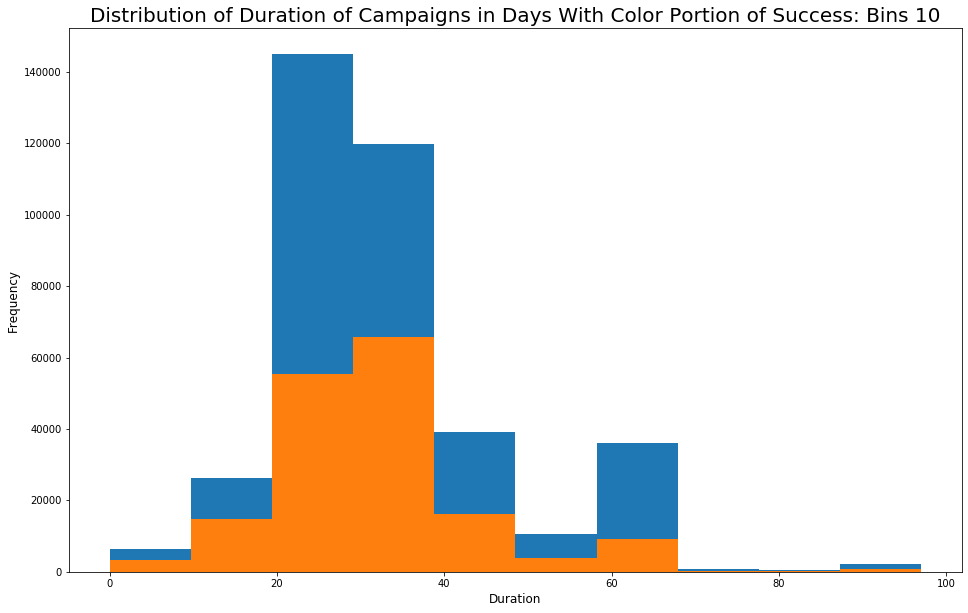

In [21]:
plt.figure(figsize = (16,10))
plt.hist(df['duration'])
plt.hist(df.loc[df['result']==1]['duration'])
plt.title('Distribution of Duration of Campaigns in Days With Color Portion of Success: Bins 10',fontsize = 20)
plt.xlabel('Duration',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)
plt.tight_layout;

In [8]:
plt.figure(figsize = (16,10))
plt.hist(df_cov['duration'])
plt.hist(df_cov.loc[df_cov['result']==1]['duration'])
plt.title('Covid-19: Distribution of Duration of Campaigns in Days With Color Portion of Success: Bins 10',fontsize = 20)
plt.xlabel('Duration',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)

NameError: name 'df_cov' is not defined

<Figure size 1152x720 with 0 Axes>

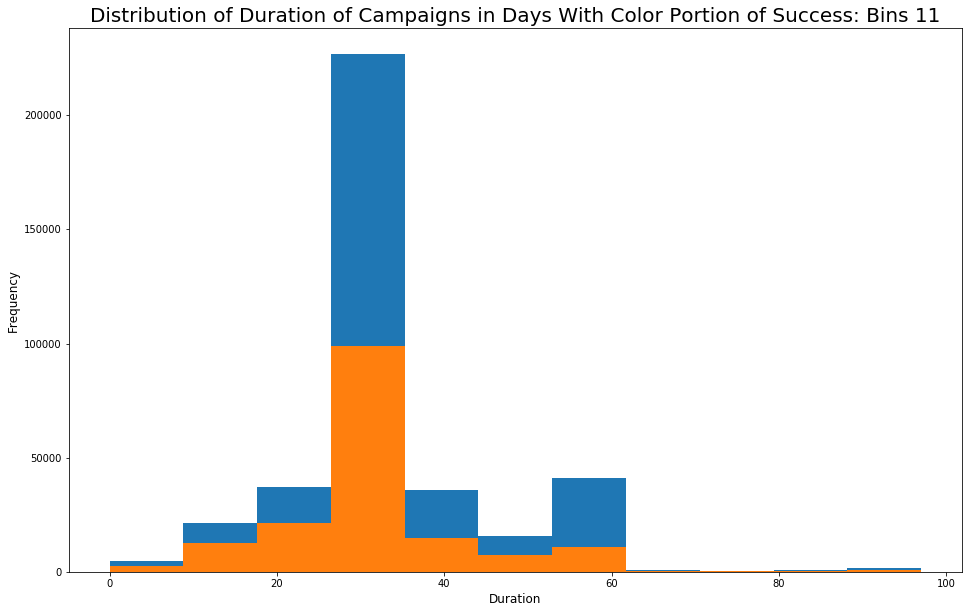

In [19]:
plt.figure(figsize = (16,10))
plt.hist(df['duration'],bins = 11)
plt.hist(df.loc[df['result']==1]['duration'],bins = 11)
plt.title('Distribution of Duration of Campaigns in Days With Color Portion of Success: Bins 11',fontsize = 20)
plt.xlabel('Duration',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)
plt.tight_layout;

In [9]:
plt.figure(figsize = (16,10))
plt.hist(df_cov['duration'],bins = 11)
plt.hist(df_cov.loc[df_cov['result']==1]['duration'],bins = 11)
plt.title('Covid-19: Distribution of Duration of Campaigns in Days With Color Portion of Success: Bins 11',fontsize = 20)
plt.xlabel('Duration',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)

NameError: name 'df_cov' is not defined

<Figure size 1152x720 with 0 Axes>

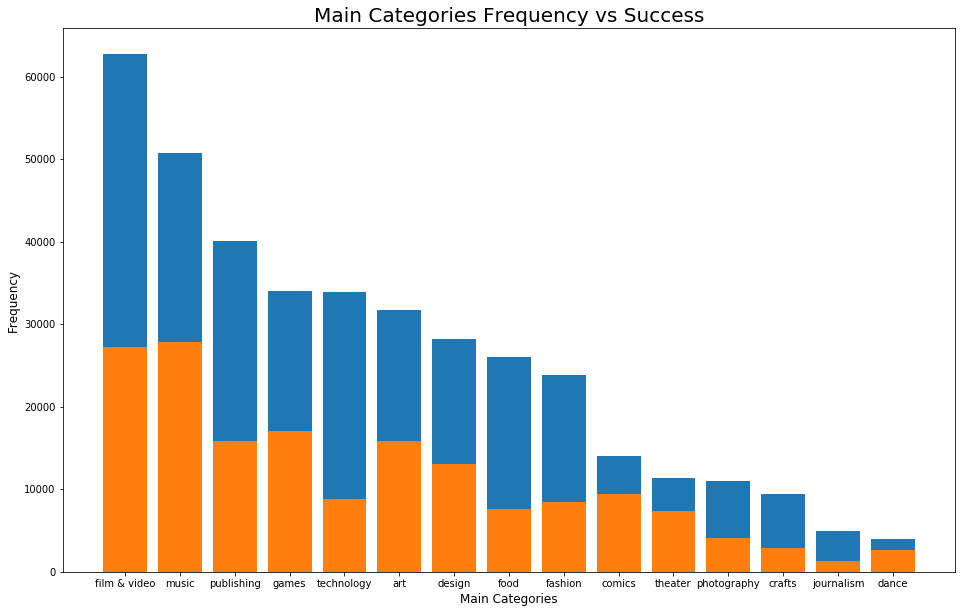

In [11]:
plt.figure(figsize = (16,10))
plt.bar(x = df['main_category'].value_counts().keys(), height = df['main_category'].value_counts())
plt.bar(x = df.loc[df['result']==1]['main_category'].value_counts().keys(), height = df.loc[df['result']==1]['main_category'].value_counts())
plt.xlabel('Main Categories', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Main Categories Frequency vs Success', fontsize = 20)
plt.tight_layout;

In [12]:
plt.figure(figsize = (16,10))
plt.bar(x = df_cov['main_category'].value_counts().keys(), height = df_cov['main_category'].value_counts())
plt.bar(x = df_cov.loc[df_cov['result']==1]['main_category'].value_counts().keys(), height = df_cov.loc[df_cov['result']==1]['main_category'].value_counts())
plt.xlabel('Main Categories', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.title('Covid-19: Main Categories Frequency vs Success', fontsize = 20)
plt.tight_layout;

NameError: name 'df_cov' is not defined

<Figure size 1152x720 with 0 Axes>

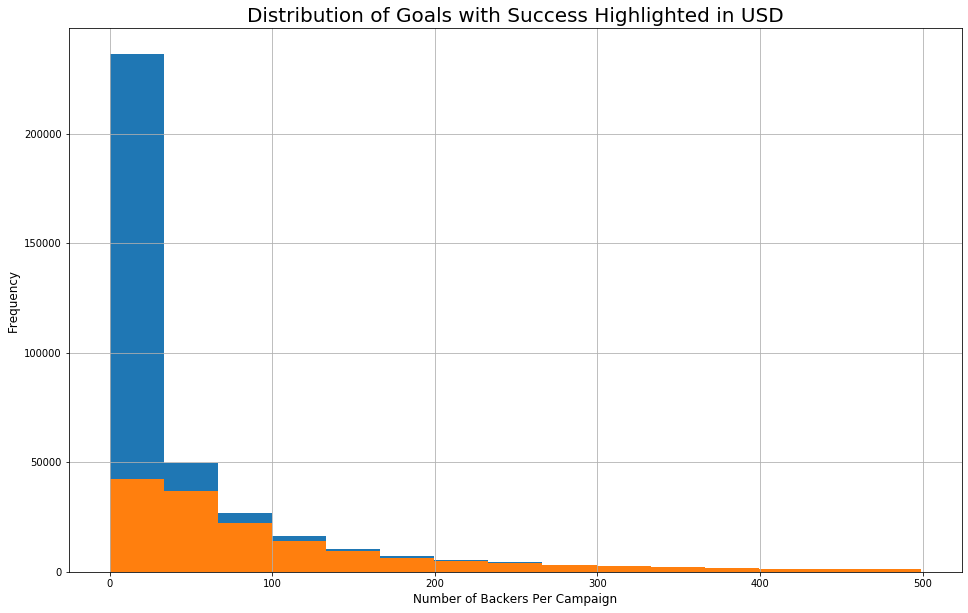

In [13]:
plt.figure(figsize = (16,10))
df.loc[(df['backers'] < 500)]['backers'].hist(bins = 15)
df.loc[(df['backers']<500) & (df['result']==1)]['backers'].hist(bins = 15)
plt.xlabel('Number of Backers Per Campaign',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)
plt.title('Distribution of Goals with Success Highlighted in USD',fontsize = 20)
plt.tight_layout;

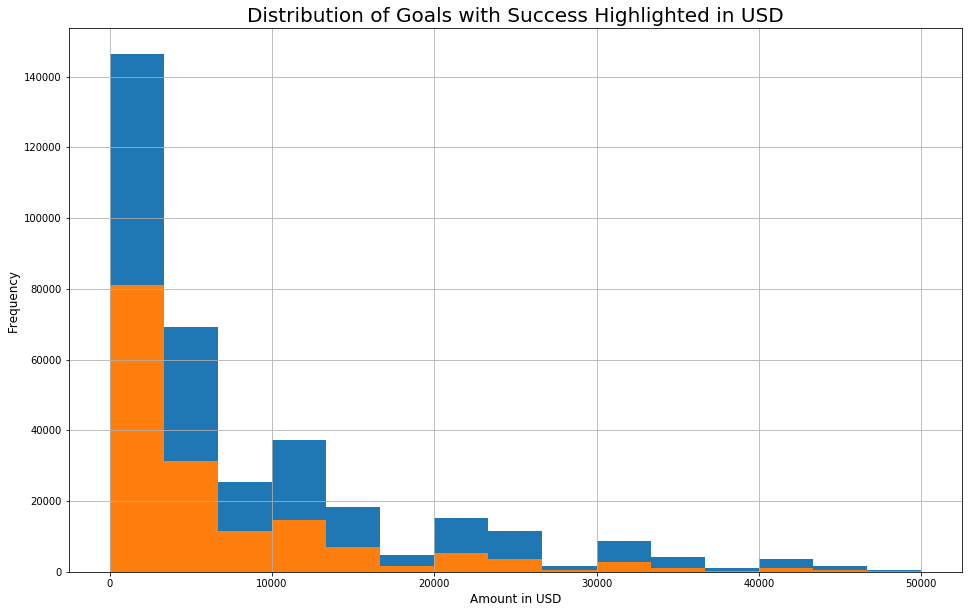

In [15]:
plt.figure(figsize = (16,10))
df[df['goal']<50000]['goal'].hist(bins = 15)
df[(df['goal']<50000)&(df['result']==1)]['goal'].hist(bins = 15)
plt.xlabel('Amount in USD',fontsize = 12)
plt.ylabel('Frequency',fontsize = 12)
plt.title('Distribution of Goals with Success Highlighted in USD',fontsize = 20)
plt.tight_layout;

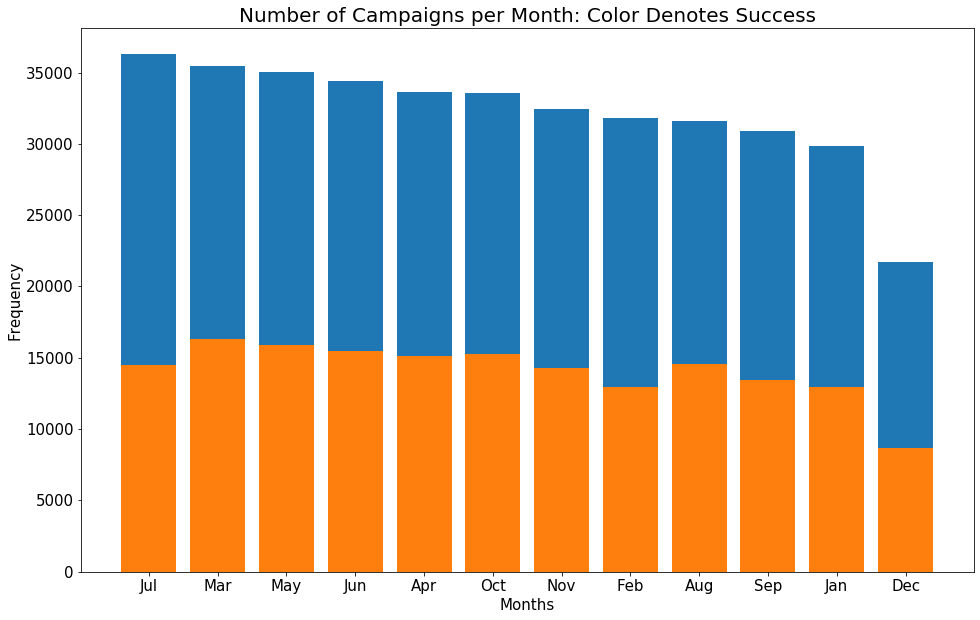

In [16]:
plt.figure(figsize = (16,10))
plt.bar(x = df['month_launched'].value_counts().keys(), height = df['month_launched'].value_counts())
plt.bar(x = df.loc[df['result']==1]['month_launched'].value_counts().keys(), height = df.loc[df['result']==1]['month_launched'].value_counts())
plt.xlabel('Months', fontsize = 15)
plt.ylabel('Frequency', fontsize = 15)
plt.title('Number of Campaigns per Month: Color Denotes Success', fontsize = 20)
plt.xticks(np.arange(12), (['Jul','Mar','May','Jun','Apr','Oct','Nov','Feb','Aug','Sep','Jan','Dec']),fontsize = 15)
plt.yticks(fontsize = 15)
plt.tight_layout;